In [3]:
import pandas as pd
import aeon.io.api as aeon
import matplotlib.pyplot as plt
from aeon.schema.dataset import exp01
from aeon.analysis.utils import visits, distancetravelled
from functools import partial

In [8]:
root = '/ceph/aeon/aeon/data/raw/AEON/experiment0.1'
events = aeon.load(root, exp01.SessionData)                           # load all sessions

PosixPath('/ceph/aeon/aeon/data/raw/AEON/experiment0.1/2021-06-03T08-23-55/FrameTop/FrameTop_2021-06-03T07-00-00.csv')

In [15]:
sessions = events[events.id.str.startswith('BAA')]                    # take only proper sessions
if len(sessions) % 2 != 0:                                            # if number of sessions don't pair up
    sessions = sessions.drop(sessions.index[-1])                      #   drop last session (might be ongoing)
sessions = visits(sessions, onset='Start', offset='End')              # compute session duration
sessions

,id,weight_start,weight_end,start,end,duration
0,BAA-1099790,25.2,26.9,2021-06-03 08:37:52.918399811,2021-06-03 13:18:41.202020168,0 days 04:40:48.283620357
1,BAA-1099794,21.9,26.2,2021-06-03 13:49:49.323520184,2021-06-03 18:01:51.744060040,0 days 04:12:02.420539856
2,BAA-1099790,24.9,28.7,2021-06-04 07:46:35.178850174,2021-06-04 12:36:28.512420177,0 days 04:49:53.333570003
3,BAA-1099794,22.5,27.1,2021-06-04 12:51:41.763460159,2021-06-04 17:10:50.035099983,0 days 04:19:08.271639824
4,BAA-1099790,24.9,28,2021-06-07 08:16:34.970530033,2021-06-07 12:35:53.705279827,0 days 04:19:18.734749794
...,...,...,...,...,...,...
184,BAA-1099790,24.2,24,2021-12-11 08:55:23.251900196,2021-12-11 15:38:21.189949989,0 days 06:42:57.938049793
185,BAA-1099791,24.5,23.5,2021-12-13 07:26:42.117539883,2021-12-13 14:05:26.431550026,0 days 06:38:44.314010143
186,BAA-1099795,23.6,23.5,2021-12-13 14:17:51.240029812,2021-12-13 19:32:45.731100082,0 days 05:14:54.491070270
187,BAA-1099795,22.9,22.3,2021-12-14 08:52:24.751840115,2021-12-14 18:29:22.048580170,0 days 09:36:57.296740055


BAA-1099790 on 2021-06-03 08:37:52.918399811...


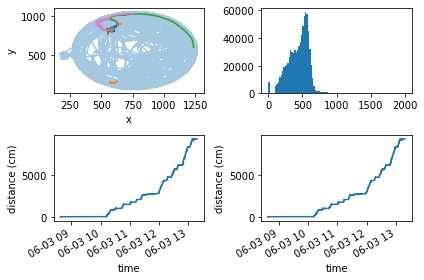

In [16]:
session = sessions.iloc[0]                                                    # pick a session
print('{0} on {1}...'.format(session.id, session.start))                      # print session report
sessiondata = partial(aeon.load, root, start=session.start, end=session.end)  # get session data loader between start and end

position = sessiondata(exp01.FrameTop.Position)                               # get position data
position = position[position.area < 2000]                                     # filter for objects of the correct size

encoder1 = sessiondata(exp01.Patch1.Encoder)                                  # get encoder data for patch1
encoder2 = sessiondata(exp01.Patch2.Encoder)                                  # get encoder data for patch2
pellets1 = sessiondata(exp01.Patch1.DeliverPellet)                            # get pellet events for patch1
pellets2 = sessiondata(exp01.Patch2.DeliverPellet)                            # get pellet events for patch2

wheel1 = distancetravelled(encoder1.angle)                                    # compute total distance travelled on patch1 wheel
wheel2 = distancetravelled(encoder2.angle)                                    # compute total distance travelled on patch2 wheel

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)                            # create a figure with subplots
ax1.plot(position.x, position.y, alpha=0.4)                                   # plot position data as a path trajectory
forage = position.reindex(pellets1.index, method='nearest')                   # get position data when a pellet is delivered at patch1
forage.plot.scatter('x','y',s=1,c='red',ax=ax1)                               # plot mouse positions when pellets were delivered

for trial in pellets1.itertuples():                                           # for each pellet delivery
    before = trial.Index - pd.to_timedelta(10, 's')                           # get the previous 10 seconds
    path = position.loc[before:trial.Index]                                   # get position data in the time before pellet delivery
    ax1.plot(path.x, path.y)                                                  # plot path traces preceding pellet delivery

ax2.hist(position.area, bins=100)                                             # plot histogram of tracked object size

wheel1.plot(ax=ax3)                                                           # plot distance travelled on patch1 wheel
wheel1.plot(ax=ax4)                                                           # plot distance travelled on patch2 wheel
ax3.set_ylabel('distance (cm)')                                               # set axis label
ax4.set_ylabel('distance (cm)')                                               # set axis label
fig.tight_layout()
plt.show()